In [87]:
# imports and setup 

import pandas as pd
import numpy as np

import torchvision
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch import Tensor

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold

In [88]:
# Create data fram with only m_label and pixel values
df = pd.read_csv("ARIAL.csv")
df = df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
# pd.set_option("display.max_rows", 30, "display.max_columns", None)
df

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,48,1,1,1,1,1,1,154,255,255,...,255,255,255,154,1,1,1,1,1,1
1,50,4,7,22,49,97,120,139,156,162,...,213,225,229,239,240,240,221,209,116,95
2,83,1,1,1,1,255,255,255,255,255,...,255,255,255,255,255,255,1,1,1,1
3,48,1,1,1,1,1,114,255,255,255,...,1,1,1,1,1,1,1,1,1,1
4,54,1,1,1,1,1,1,1,1,255,...,255,255,255,255,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26232,37,1,4,83,208,255,255,161,16,1,...,1,1,16,161,255,255,208,83,4,1
26233,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
26234,35,1,1,1,1,1,1,77,253,255,...,255,255,253,77,1,1,1,1,1,1
26235,34,43,255,255,255,255,255,255,255,255,...,43,255,255,255,255,213,1,1,1,1


In [89]:
df_pixel_values = df.drop(columns=['m_label'])
pixel_array = np.array(df_pixel_values)
# np.set_printoptions(threshold=np.inf)
pixel_array = pixel_array.astype(float)
for i in range(len(pixel_array)):
    for j in range(len(pixel_array[0])):
        pixel_array[i][j] = pixel_array[i][j] / 256

In [90]:
Xs = pixel_array # 20 x 20 array containing the pixel values
print(Xs.shape)
Xs_arial = np.reshape(Xs, (-1, 1, 20, 20))
print(Xs_arial.shape)
arial_chars = set(df['m_label'])
uniqueChars = len(arial_chars)
char_to_ix = {char: i for i, char in enumerate(arial_chars)}
asciiValues = df['m_label']
lst = []
for ascii_val in asciiValues:
    lst.append(char_to_ix[ascii_val]) # creating list of index values of each ascii char label

Ys_arial = np.array(lst) # convert list to numpy array

(26237, 400)
(26237, 1, 20, 20)


In [91]:
# Split data into testing and training sets
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs_arial, Ys_arial, random_state=1, test_size=0.75)
Xs_train = torch.tensor(Xs_train, dtype = torch.float)
Ys_train = torch.tensor(Ys_train, dtype = torch.float)
Xs_test = torch.tensor(Xs_test, dtype = torch.float)
Ys_test = torch.tensor(Ys_test, dtype = torch.float)

In [92]:
tensor_test = TensorDataset(Xs_test, Ys_test) 
tensor_train = TensorDataset(Xs_train, Ys_train) 

In [93]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 6 # convoluation layer 1 will output 6 "images": one for each filter it trains
        c2Out = 16 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 3) #1-D input, c1Out outputs, filter size 3x3 pixels
        
        # (28-2)*(28 -2)*c1Out outputs

        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value
        
        # 13*13*c1Out
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #inputs comes from conv1 , specify our #outputs, use 3x3 blocks again
        
        # (13-2)*(13 -2)*c2Out
        # pool again
        # (11/2)*(11/2)*c2Out = 5*5*c2Out
        
        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out*3*3 # 16 outputs per image whose size has been reduced
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, 3098)

    def forward(self, x): # "batch" of images
        #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)
        # print("Before 1st: " + str(x.shape))
        # x = F.relu(self.conv1(x))
        x = self.conv1(x)
        # print("x = self.conv1(x) " + str(x.shape))
        x = F.relu(x)
        # print("x = F.relu(x) " + str(x.shape))
        x = self.pool(x)
        # print("Max Pool: " + str(x.shape))
        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        # x = self.pool(F.relu(self.conv2(x))) #ditto
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        x = self.pool(x)
        # print("after pool before flatten " + str(x.shape))
        #print(x.shape) #uncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be
        
        
        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        # print("after flatten " + str(x.shape))
        # x = x.view(x.shape[0], -1)  #equivalent ways of reshaping the data to be 1D
        # x = x.view(batch_size( x.shape[0]) , -1)
        # print("after x = x.view(-1, self.num_flat_features(x)) " + str(x.shape))
        
        # x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc1(x)
        # print("dense layer1 " + str(x.shape))
        x = F.relu(x)
        # print(x.shape)
        # x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc2(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [94]:
def train(model, epochs, tensor_train):
    criterion = nn.CrossEntropyLoss() #this is a way of measuring error for classification that takes the
    #"confidence" of a prediction into account.  High confidence, correct predictions are low cost, 
    #high confidence, wrong predictions are high cost, medium confidence predictions have cost

    #use the ADAM optimizer to find the best weights
    optimizer = optim.Adam(model.parameters(), lr= 1e-4) 
    
    #this loads data and gets it in the right format for us
    trainloader = torch.utils.data.DataLoader(tensor_train, batch_size=8, shuffle=True, num_workers=0)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs) #predict the output with some training data
            loss = criterion(outputs, labels.to(torch.long)) #see how well we did
            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def evaluate(model, tensor_test):  
    #load some test data
    testloader = torch.utils.data.DataLoader(tensor_test, batch_size=8,
                                                shuffle=True, num_workers=0)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #just do a coarse evaluation... how many did we predict correcly?
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [95]:
train(net, 8, tensor_train)
evaluate(net, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 21 %


The accuracy of the network seems to be between 11% - 22% after running it multiple times. 

In [96]:
class NxtNet(nn.Module):
    def __init__(self, uniqueChars):
        super(NxtNet, self).__init__()
        c1Out = 10 # convoluation layer 1 will output 6 "images": one for each filter it trains
        c2Out = 20 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 3) #1-D input, c1Out outputs, filter size 3x3 pixels

        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #inputs comes from conv1 , specify our #outputs, use 3x3 
        self.conv2_norm = nn.BatchNorm2d(20)
        self.pooledOutputSize = c2Out*3*3 
        self.fc1 = nn.Linear(self.pooledOutputSize, 240)
        self.fc2 = nn.Linear(240, uniqueChars)

    def forward(self, x): # "batch" of images
        #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)
        # print("Before 1st: " + str(x.shape))
        # x = F.relu(self.conv1(x))
        x = self.conv1(x)
        # print("x = self.conv1(x) " + str(x.shape))
        x = F.relu(x)
        # print("x = F.relu(x) " + str(x.shape))
        x = self.pool(x)
        # print("Max Pool: " + str(x.shape))
        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        # x = self.pool(F.relu(self.conv2(x))) #ditto
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv2_norm(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.pool(x)
        # print("after pool before flatten " + str(x.shape))
        #print(x.shape) #uncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be
        
        
        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        # print("after flatten " + str(x.shape))
        # x = x.view(x.shape[0], -1)  #equivalent ways of reshaping the data to be 1D
        # x = x.view(batch_size( x.shape[0]) , -1)
        # print("after x = x.view(-1, self.num_flat_features(x)) " + str(x.shape))
        
        # x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc1(x)
        # print("dense layer1 " + str(x.shape))
        x = F.relu(x)
        # print(x.shape)
        # x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc2(x)
        # print(x.shape)
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


nxtnet = NxtNet(uniqueChars)

In [97]:
train(nxtnet, 20, tensor_train)
evaluate(nxtnet, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 49 %


Adding batch normalization to the 2nd convolution increased accuracy from 12% to 49%

In [133]:
book_data = pd.read_csv("AGENCY.csv")
book_data

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,AGENCY,AGENCY FB,64258,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
1,AGENCY,AGENCY FB,64257,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
2,AGENCY,AGENCY FB,61442,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
3,AGENCY,AGENCY FB,61441,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
4,AGENCY,AGENCY FB,9674,0.4,0,0.0,51,21,33,25,...,255,132,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,AGENCY,AGENCY FB,37,0.7,1,0.0,35,27,51,48,...,255,255,255,231,114,1,1,1,1,1
1000,AGENCY,AGENCY FB,36,0.7,1,0.0,30,24,61,40,...,1,1,1,1,1,1,1,1,1,1
1001,AGENCY,AGENCY FB,35,0.7,1,0.0,35,25,51,44,...,1,1,1,1,1,1,1,1,1,1
1002,AGENCY,AGENCY FB,34,0.7,1,0.0,35,35,16,21,...,255,255,255,255,73,1,1,1,1,1


In [134]:
book_data = book_data.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
book_pixel_values = book_data.drop(columns=['m_label'])
book_pixel_array = np.array(book_pixel_values)
book_pixel_array = book_pixel_array.astype(float)
for i in range(len(book_pixel_array)):
    for j in range(len(book_pixel_array[0])):
        book_pixel_array[i][j] = book_pixel_array[i][j] / 256

In [135]:
Xs = book_pixel_array # 20 x 20 array containing the pixel values
Xs = np.reshape(Xs, (-1, 1, 20, 20))
book_chars = set(book_data['m_label'])
uniqueChars = len(book_chars)
char_to_ix = {char: i for i, char in enumerate(book_chars)}
asciiValues = book_data['m_label']
lst = []
for ascii_val in asciiValues:
    lst.append(char_to_ix[ascii_val]) # creating list of index values of each ascii char label

Ys = np.array(lst) # convert list to numpy array
print(len(Ys))
print(len(Xs))

1004
1004


In [136]:
xs = Xs
ys = Ys

In [137]:
# Split data into testing and training sets
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs, Ys, random_state=1, test_size=0.75)
Xs_train = torch.tensor(Xs_train, dtype = torch.float)
Ys_train = torch.tensor(Ys_train, dtype = torch.float)
Xs_test = torch.tensor(Xs_test, dtype = torch.float)
Ys_test = torch.tensor(Ys_test, dtype = torch.float)

In [138]:
tensor_test = TensorDataset(Xs_test, Ys_test) 
tensor_train = TensorDataset(Xs_train, Ys_train) 

**Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?**

In [139]:
xs = torch.tensor(xs, dtype=torch.float)
ys = torch.tensor(ys, dtype= torch.float)
full_data = TensorDataset(xs, ys)
evaluate(nxtnet, full_data)

Accuracy of the network on the 10000 test images: 10 %


**The accuracy is much worse when testing characters from a different font set, going down from 49% to 10%. It makes sense that it wouldn't do as well predicting characters from a font it did not train on.**

In [105]:
train(nxtnet, 20, tensor_train)
evaluate(nxtnet, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 3 %


In [106]:
train(net, 20, tensor_train)
evaluate(net, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 0 %


In [107]:
bestNet = nxtnet
f = pd.read_csv('AGENCY.csv')
f2 = pd.read_csv('BRUSH.csv')
f3 = pd.read_csv('BOOK.csv')
data1 = f.loc[:, 'r0c0':]
data2 = f2.loc[:, 'r0c0':]
data3 = f3.loc[:, 'r0c0':]

mixed_fonts_labels = pd.concat([f['m_label'], f2['m_label'], f3['m_label']]).reset_index(drop=True)
mixed_fonts = pd.concat([data1, data2, data3]).reset_index(drop=True)

In [108]:
Xs = np.array(mixed_fonts)
Xs = Xs.astype(float)
for i in range(len(Xs)):
    for j in range(len(Xs[0])):
        Xs[i][j] = Xs[i][j] / 256
Xs = np.reshape(Xs, (-1, 1, 20, 20))
chars = set(mixed_fonts_labels)
uniqueChars = len(chars)
char_to_ix = {char: i for i, char in enumerate(chars)}
asciiValues = mixed_fonts_labels
lst = []
for ascii_val in asciiValues:
    lst.append(char_to_ix[ascii_val]) # creating list of index values of each ascii char label

Ys_mixed = np.array(lst) # convert list to numpy array
Xs_mixed = Xs
print(Ys_mixed.shape)
print(Xs_mixed.shape)

(4628,)
(4628, 1, 20, 20)


In [109]:
Xs_mixed_train, Xs_mixed_test, Ys_mixed_train, Ys_mixed_test = train_test_split(Xs_mixed[:-len(f3)], Ys_mixed[:-len(f3)])
Xs_mixed_train = torch.tensor(Xs_mixed_train, dtype = torch.float)
Ys_mixed_train = torch.tensor(Ys_mixed_train, dtype = torch.float)
Xs_mixed_test = torch.tensor(Xs_mixed_test, dtype = torch.float)
Ys_mixed_test = torch.tensor(Ys_mixed_test, dtype = torch.float)

In [110]:
tensor_mixed_test = TensorDataset(Xs_mixed_test, Ys_mixed_test) 
tensor_mixed_train = TensorDataset(Xs_mixed_train, Ys_mixed_train) 

In [112]:
best_network_mixed = NxtNet(uniqueChars)


train(best_network_mixed, 20, tensor_mixed_train)
evaluate(best_network_mixed, tensor_mixed_test)


Finished Training
Accuracy of the network on the 10000 test images: 45 %


**Accuracy increased from 1% - 52% using the multiple font set instead of 1 font.**

In [113]:
test_data_not_trained = TensorDataset( Tensor(Xs_mixed[-len(f3):]), Tensor(Ys_mixed[-len(f3):]).to(torch.long))

evaluate(best_network_mixed, test_data_not_trained)

Accuracy of the network on the 10000 test images: 11 %


**Accuracy is lower when testing with inputs from a font not trained on. It kinda makes sense, even though the model was trained with two different fonts, it wasn't trained in this one, so it is not prepared to classify this font style correctly.**  

In [114]:
unicode_to_labels = {unicode: i for i, unicode in enumerate(chars) }
labels_to_unicode = {label: unicode for unicode, label in unicode_to_labels.items() }

In [115]:
def getMisclassified(model, test_data):
    test_to_predict = [] # CHANGE THIS
    testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0)
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_to_predict += list(zip(list(labels.numpy()), list(predicted.numpy())))

    misclassified = []

    for i, item in enumerate(test_to_predict):
        if (item[0] != item[1]):
            actual = chr(labels_to_unicode[item[0]])
            predicted = chr(labels_to_unicode[item[1]])
            misclassified.append((i, actual, predicted))

    return misclassified

In [116]:
missed = getMisclassified(best_network_mixed, tensor_mixed_test)

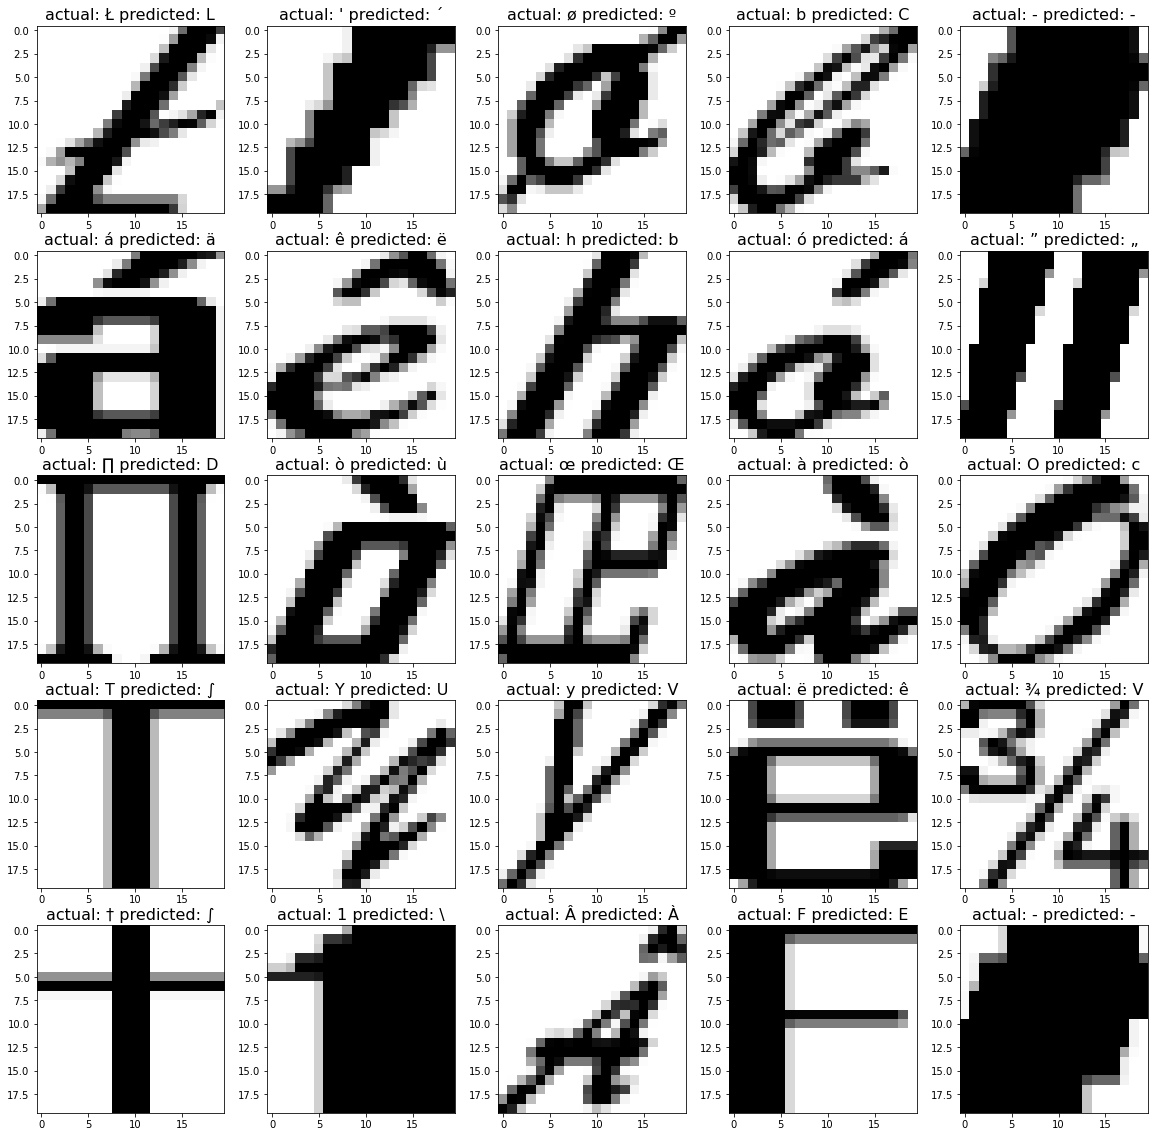

In [117]:
plt.figure(figsize=(20,20))
for ii in np.arange(25):
    index = missed[ii][0]
    actual_chr = missed[ii][1]
    predicted_chr = missed[ii][2]

    plt.subplot(5, 5, ii+1)
    plt.imshow(Xs_mixed_test[index, 0, :, :], cmap='Greys', interpolation='none')
    plt.title("actual: " + actual_chr + " predicted: " + predicted_chr, fontsize=16)

**The pattern I see in missed classifications is they seem to be characters that are similar to other characters. I wasn't able to find any examples where the netword was unsure of the result. For all misclassified characters it has a prediction, but the prediction is wrong.**

In [121]:
Xs_arial = (Xs_arial + np.random.rand(Xs_arial.shape[0], Xs_arial.shape[1], Xs_arial.shape[2], Xs_arial.shape[3])) / 2

In [122]:
len(Xs_arial)

26237

In [123]:
Xs_train_arial, Xs_test_arial, Ys_train_arial, Ys_test_arial = train_test_split(Xs_arial, Ys_arial, random_state=1, test_size=0.75)

Xs_train_arial = torch.tensor(Xs_train_arial, dtype = torch.float)
Ys_train_arial = torch.tensor(Ys_train_arial, dtype = torch.float)
Xs_test_arial = torch.tensor(Xs_test_arial, dtype = torch.float)
Ys_test_arial = torch.tensor(Ys_test_arial, dtype = torch.float)

train_data_arial = TensorDataset(Xs_train_arial, Ys_train_arial) 
test_data_arial = TensorDataset(Xs_test_arial, Ys_test_arial)

In [124]:
class AutoEncoderNet(nn.Module):
    def __init__(self):
        super(AutoEncoderNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        #the padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        #output is 8x 28x28 images
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 20//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

autoencoder_net = AutoEncoderNet() # treat these as just 28 D vectors

In [125]:
#same as we did before except for the reshaping.  CNNs understand 2D images, so we don't want to flatten

# mean-squared error loss
# this is the normal "least squares" error function, divided by the number of data points
criterion = nn.MSELoss()

def train_autoencoder(model, training_data, epochs):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
    train_loader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            #same as yesterday, except we're not even looking at the labels!
            # since we're not using a CNN, we need to "flatten" the input images
            batch_features = data[0]
        
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(batch_features)
            #print(batch_features.shape)
            #print(outputs.shape)
            # compute training reconstruction loss
            # again, same idea as yesterday, but we're measuring the error slightly differently
            # how well does the reconstructed image match the input image?
            train_loss = criterion(outputs, batch_features)
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, running_loss/len(train_loader)))

def evaluate_autoencoder(model, test_data):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

In [126]:
train_autoencoder(autoencoder_net, train_data_arial, 2)
evaluate_autoencoder(autoencoder_net, test_data_arial)

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


epoch : 1/2, loss = 0.00000000
epoch : 2/2, loss = 0.00000000
overall loss:  104.55353999696672


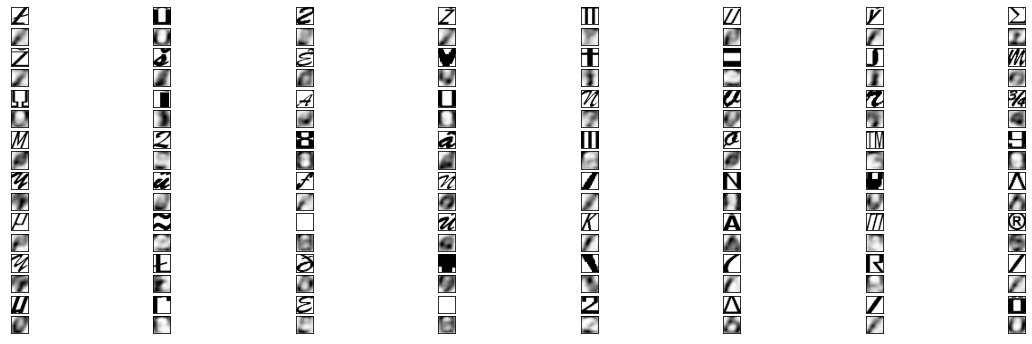

In [127]:
def drawComparisons(model, testing_data):
    test_loader = torch.utils.data.DataLoader(testing_data, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 6))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):
                #draw the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                #and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisons(autoencoder_net, tensor_mixed_test)

In [128]:
compressed = np.array([.25,.5,.5,.5])
compressed = torch.tensor(compressed, dtype=torch.float)

In [129]:
output = autoencoder_net.decompress(compressed)
plt.imshow(output.detach().numpy().reshape(20,20), cmap="Greys", interpolation=None)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 32x64)